# 第4章: 形態素解析

夏目漱石の小説『吾輩は猫である』の文章（neko.txt）をMeCabを使って形態素解析し、  
その結果をneko.txt.mecabというファイルに保存せよ。  
このファイルを用いて，以下の問に対応するプログラムを実装せよ。  
なお，問題37, 38, 39はmatplotlibもしくはGnuplotを用いるとよい。  

### 形態素解析

文章を文法に基づき形態素（意味をもつ最小単位に分割）に分割し、  
品詞などの解析を行う。  
その語がどんな品詞で元はどんな形なのかなどを知ることができる。  
単語の出現頻度を調べることができる。  
応用例は構文解析や単語のベクトル表現など。  

mecabと辞書をインストールする。

```
$ brew install mecab
$ brew install mecab-ipadic
```

以下にインストールされた。

```
/usr/local/etc/mecabrc
/usr/local/bin/mecab
/usr/local/bin/mecab-config
```

動作確認を行う。以下を入力。

```
$ mecab
MeCab はフリーソフトウェアです
```

実行結果

```
MeCab   名詞,固有名詞,組織,*,*,*,*
は 助詞,係助詞,*,*,*,*,は,ハ,ワ
フリー   名詞,一般,*,*,*,*,フリー,フリー,フリー
ソフトウェア  名詞,一般,*,*,*,*,ソフトウェア,ソフトウェア,ソフトウェア
です  助動詞,*,*,*,特殊・デス,基本形,です,デス,デス
EOS
```

In [1]:
import MeCab
from MeCab import Tagger
from typing import List, Dict
import os
import re
from collections import Counter
from matplotlib import pyplot
%matplotlib inline

In [2]:
with open("./data/neko.txt", "r") as file:
    lines: List[str] = file.readlines()

text: str = "".join(lines)
tagger: Tagger = MeCab.Tagger()
parsed: str = tagger.parse(text)

with open("./data/neko.txt.mecab", "w") as file:
    file.writelines(parsed)

## 30. 形態素解析結果の読み込み

形態素解析結果（neko.txt.mecab）を読み込むプログラムを実装せよ。  
ただし、各形態素は表層形（surface）、基本形（base）、品詞（pos）、品詞細分類1（pos1）  
をキーとするマッピング型に格納し、
1文を形態素（マッピング型）のリストとして表現せよ。  
第4章の残りの問題では，ここで作ったプログラムを活用せよ。


In [3]:
with open("./data/neko.txt.mecab") as file:
    lines: List[str] = file.readlines()

# EOFの行だけ削除する
lines.pop()

dictionary_list: List[Dict[str, str]] = []
for line in lines:
    splited_list = re.split("[\t,]", line)

    surface: str = splited_list[0]
    base: str = splited_list[7]
    pos: str = splited_list[1]
    pos1: str = splited_list[2]

    dictionary: Dict[str, str] = {"surface": surface,
                                  "base": base,
                                  "pos": pos,
                                  "pos1": pos1}

    dictionary_list.append(dictionary)

# 最初の10つのみ表示
dictionary_list[:10]

[{'base': '一', 'pos': '名詞', 'pos1': '数', 'surface': '一'},
 {'base': '\u3000', 'pos': '記号', 'pos1': '空白', 'surface': '\u3000'},
 {'base': '吾輩', 'pos': '名詞', 'pos1': '代名詞', 'surface': '吾輩'},
 {'base': 'は', 'pos': '助詞', 'pos1': '係助詞', 'surface': 'は'},
 {'base': '猫', 'pos': '名詞', 'pos1': '一般', 'surface': '猫'},
 {'base': 'だ', 'pos': '助動詞', 'pos1': '*', 'surface': 'で'},
 {'base': 'ある', 'pos': '助動詞', 'pos1': '*', 'surface': 'ある'},
 {'base': '。', 'pos': '記号', 'pos1': '句点', 'surface': '。'},
 {'base': '名前', 'pos': '名詞', 'pos1': '一般', 'surface': '名前'},
 {'base': 'は', 'pos': '助詞', 'pos1': '係助詞', 'surface': 'は'}]

## 31. 動詞

動詞の表層形をすべて抽出せよ。

In [4]:
verb_list: List[str] = []
for dictionary in dictionary_list:
    if dictionary["pos"] == "動詞":
        verb_list.append(dictionary["surface"])

verb_list[:10]

['生れ', 'つか', 'し', '泣い', 'し', 'いる', '始め', '見', '聞く', '捕え']

## 33. サ変名詞

サ変接続の名詞をすべて抽出せよ。

In [5]:
verb_list: List[str] = []
for dictionary in dictionary_list:
    if dictionary["pos1"] == "サ変接続":
        verb_list.append(dictionary["surface"])

verb_list[:10]

['見当', '記憶', '話', '装飾', '突起', '運転', '記憶', '分別', '決心', '我慢']

## 34. 「AのB」

2つの名詞が「の」で連結されている名詞句を抽出せよ。

In [6]:
noun_of_noun: List[str] = []
for index in range(len(dictionary_list) - 2):
    if dictionary_list[index]["pos"] != "名詞":
        continue
    if dictionary_list[index + 1]["surface"] != "の":
        continue
    if dictionary_list[index + 2]["pos"] != "名詞":
        continue

    noun_of_noun.append(dictionary_list[index]["surface"] +
                        dictionary_list[index + 1]["surface"] +
                        dictionary_list[index + 2]["surface"])

noun_of_noun[:10]

['彼の掌', '掌の上', '書生の顔', 'はずの顔', '顔の真中', '穴の中', '書生の掌', '掌の裏', '何の事', '肝心の母親']

## 35. 名詞の連接

名詞の連接（連続して出現する名詞）を最長一致で抽出せよ。

In [7]:
noun_list: List[str] = []
noun: List[str] = []
for dictionary in dictionary_list:
     
    # 現在の単語が名詞でない場合
    if dictionary["pos"] != "名詞":
        if len(noun) >= 2:
            noun_list.append("".join(noun))
        noun = []
        continue
     
    # 名詞であるが、一つ前の単語が名詞でない場合   
    if not noun:
        noun.append(dictionary["surface"])
        continue
    
    # 名詞であるが、一つ前の名詞と一致しない場合
    if dictionary["surface"] != noun[0]:
        if len(noun) >= 2:
            noun_list.append("".join(noun))
        noun = [dictionary["surface"]]
        continue
    
    # 名詞であり、一つ前の名詞と同じものである場合
    noun.append(dictionary["surface"])

if len(noun) >= 2:
    noun_list.append("".join(noun))
    
noun_list[:10]

['毎日毎日', 'けらけら', '余所余所', '毎日毎日', '先生先生', '毎日毎日', '降参降参', 'それそれ', '○○', '愚図愚図']

## 36. 単語の出現頻度

文章中に出現する単語とその出現頻度を求め、出現頻度の高い順に並べよ。

In [8]:
word_list: List[str] = []
for dictionary in dictionary_list:
    word_list.append(dictionary["surface"])

counter: Counter = Counter(word_list)

# 上位10個の単語を表示
counter.most_common(10)

[('の', 9194),
 ('。', 7486),
 ('て', 6873),
 ('、', 6772),
 ('は', 6422),
 ('に', 6268),
 ('を', 6071),
 ('と', 5515),
 ('が', 5339),
 ('た', 3989)]

## 37. 頻度上位10語

出現頻度が高い10語とその出現頻度をグラフ（例えば棒グラフなど）で表示せよ。

pyplotの日本語表示が現状うまくいっていない。ごめんなさい。

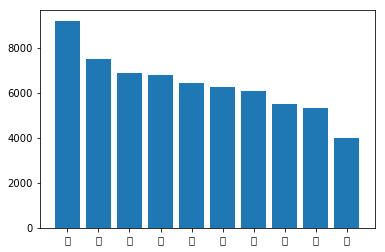

In [9]:
best_10: List[Dict[str, int]] = counter.most_common(10)

word_list: List[str] = []
count_list: List[str] = []
for word, count in best_10:
    word_list.append(word)
    count_list.append(count)

pyplot.bar(range(len(word_list)), count_list, tick_label=word_list)
pyplot.show()

## 38. ヒストグラム

単語の出現頻度のヒストグラム（横軸に出現頻度、縦軸に出現頻度をとる単語の種類数を棒グラフで表したもの）を描け。

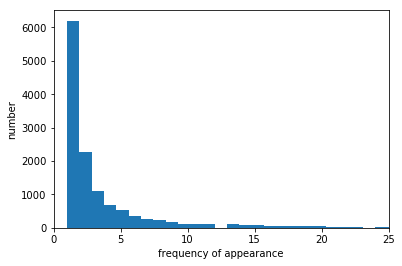

In [10]:
count_list: List[str] = []

for count in counter.most_common():
    count_list.append(count[1])

pyplot.hist(count_list, bins=10000)
pyplot.xlim(0, 25)
pyplot.ylabel("number")
pyplot.xlabel("frequency of appearance")
pyplot.show()

## 39. Zipfの法則

単語の出現頻度順位を横軸、その出現頻度を縦軸として、両対数グラフをプロットせよ。

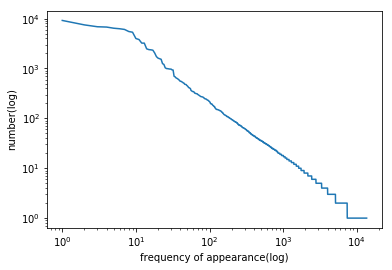

In [11]:
pyplot.loglog(range(1, len(count_list) + 1), count_list)
pyplot.ylabel("number(log)")
pyplot.xlabel("frequency of appearance(log)")
pyplot.show()